# 第6回課題
前処理と特徴量選択により，SVM の最初のスコアよりも1割程度良いテストスコアを出してください．
ちょこっといじった程度では，線形回帰はスコアが変わらなかったので，参考程度に使ってください

### 必須事項
- 前処理：正規化，標準化，外れ値の排除など
- 特徴量選択: 検証は必須．増やす・減らす・変えないの結果は自由
- テストスコアの向上: mse で 0.41 くらいは出ると思います

### 自由事項
- 指標の変更
- パラメータの変更（モデルの変更は想定してません）

### 余談
特徴量選択で正解を用意するのは，やはり難しいなと解答を作る時に感じました．解答の方は最低限の考察と検証をしていますが，4時間かかりました( ;∀;)

## 注意事項
特徴量の分析時に分割したデータを使ってない時点でせこいというか，おかしいです．ここでは無視していますが，本来はできません．

In [630]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

For more information, read [Cortez et al., 2009].
Input variables (based on physicochemical tests):

- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol

Output variable (based on sensory data):
- quality (score between 0 and 10)

In [631]:
wine_quality_df = pd.read_csv("winequality-red.csv",delimiter=";")
print(wine_quality_df.shape)
wine_quality_df.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [632]:
wine_quality_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [633]:
feature_names = list(np.copy(wine_quality_df.columns))
feature_names.remove("quality")

In [634]:
X_train, X_test, y_train, y_test = \
    train_test_split(wine_quality_df[feature_names], wine_quality_df["quality"], 
                     test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((1119, 11), (480, 11))

## 注意
ここで，test score まで同時に出してしまっているんですが，1つの関数で実行してしまう方が楽だったという理由だけで，これらは分けた方が良いです．
パラメータや特徴量について考えるときには，CV だけで調整すべきです

In [635]:
kfold = KFold(n_splits=5, random_state=0)
def cross_validation(model, test=True, return_test=False):
    global X_train, X_test, y_train, y_test, feature_names
    scores = cross_val_score(model, X_train[feature_names], y_train, cv=kfold, 
                             scoring=make_scorer(mean_squared_error))
    # 各分割におけるスコア
    print('Cross-Validation scores: {}'.format(scores))
    # スコアの平均値
    print('Average score: {}'.format(np.mean(scores)))
    if test:
        model.fit(X_train[feature_names], y_train)
        pred = model.predict(X_test[feature_names])
        print('Test score: {}'.format(mean_squared_error(y_test, pred)))
    if return_test == False:  
        return np.mean(scores)
    else:
        return mean_squared_error(y_test, pred)

# モデルによる予測

In [636]:
linear_reg = Ridge(random_state=0)
cross_validation(linear_reg)

Cross-Validation scores: [0.48812538 0.48841541 0.42327305 0.42566563 0.36728215]
Average score: 0.43855232598926497
Test score: 0.4010466305154149


0.43855232598926497

In [637]:
svm_clf = SVC(kernel="rbf", random_state=0)
cross_validation(svm_clf)

Cross-Validation scores: [0.67857143 0.82142857 0.71428571 0.75446429 0.62780269]
Average score: 0.719310538116592
Test score: 0.68125


0.719310538116592

In [638]:
svm_reg = SVR(kernel="rbf")
cross_validation(svm_reg)

Cross-Validation scores: [0.5715145  0.68175944 0.57909369 0.61098986 0.50245379]
Average score: 0.5891622546486783
Test score: 0.5085468469038228


0.5891622546486783

# 以降にコードを追加

## 正規化

In [639]:
from sklearn.preprocessing import StandardScaler

In [640]:
# cross_validation 関数を利用するため、変数名はそのままで上書き
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

## 外れ値の排除
MATLABの外れ値検出方法 (https://jp.mathworks.com/help/matlab/ref/isoutlier.html) を参考に、
中央絶対偏差の3倍離れている値を外れ値として扱ってみる。

In [641]:
wine_quality_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [642]:
def median_absolute_derivation(col):
    return (col-col.median()).abs().median()

def outlier(col, n):
    # 外れ値ならTrue、 他Falseの配列を返す。
    # nが大きいほど外れ値となる値は少なくなる。
    return (col.median() - col).abs() > n * median_absolute_derivation(col)

In [643]:
# 3倍だと外れ値があまりにも多い
for col in X_train.columns:
    out_row = outlier(X_train[col], 3)
    print(X_train[out_row].shape[0])

103
48
5
158
143
62
127
89
56
108
86


In [644]:
# この方法では列ごとに n の値を変える必要がありそうだが、調節して浮かび出たデータが外れ値と言えるのか疑問が残るため断念。
for col in X_train.columns:
    out_row = outlier(X_train[col], 10)
    print(X_train[out_row].shape[0])

0
0
0
53
34
0
2
0
0
8
0


## スコア
正規化を行っただけで線形回帰以外はだいぶスコアの向上が見られた

In [645]:
cross_validation(linear_reg)

Cross-Validation scores: [0.49239137 0.48985979 0.43040695 0.42268956 0.36400115]
Average score: 0.43986976362616453
Test score: 0.400785914008989


0.43986976362616453

In [646]:
cross_validation(svm_clf)

Cross-Validation scores: [0.56696429 0.52678571 0.5        0.52678571 0.4529148 ]
Average score: 0.5146901024983984
Test score: 0.4583333333333333


0.5146901024983984

In [647]:
cross_validation(svm_reg)

Cross-Validation scores: [0.45148575 0.42211498 0.38000374 0.4269028  0.3493321 ]
Average score: 0.40596787342893403
Test score: 0.38737273064964606


0.40596787342893403

## 特徴量選択
目的変数との相関の弱い特徴量は重要でないと仮定

他の特徴量との相関の強い特徴量は、他の特徴量で説明できるため重要でないと仮定（多重共線性？）

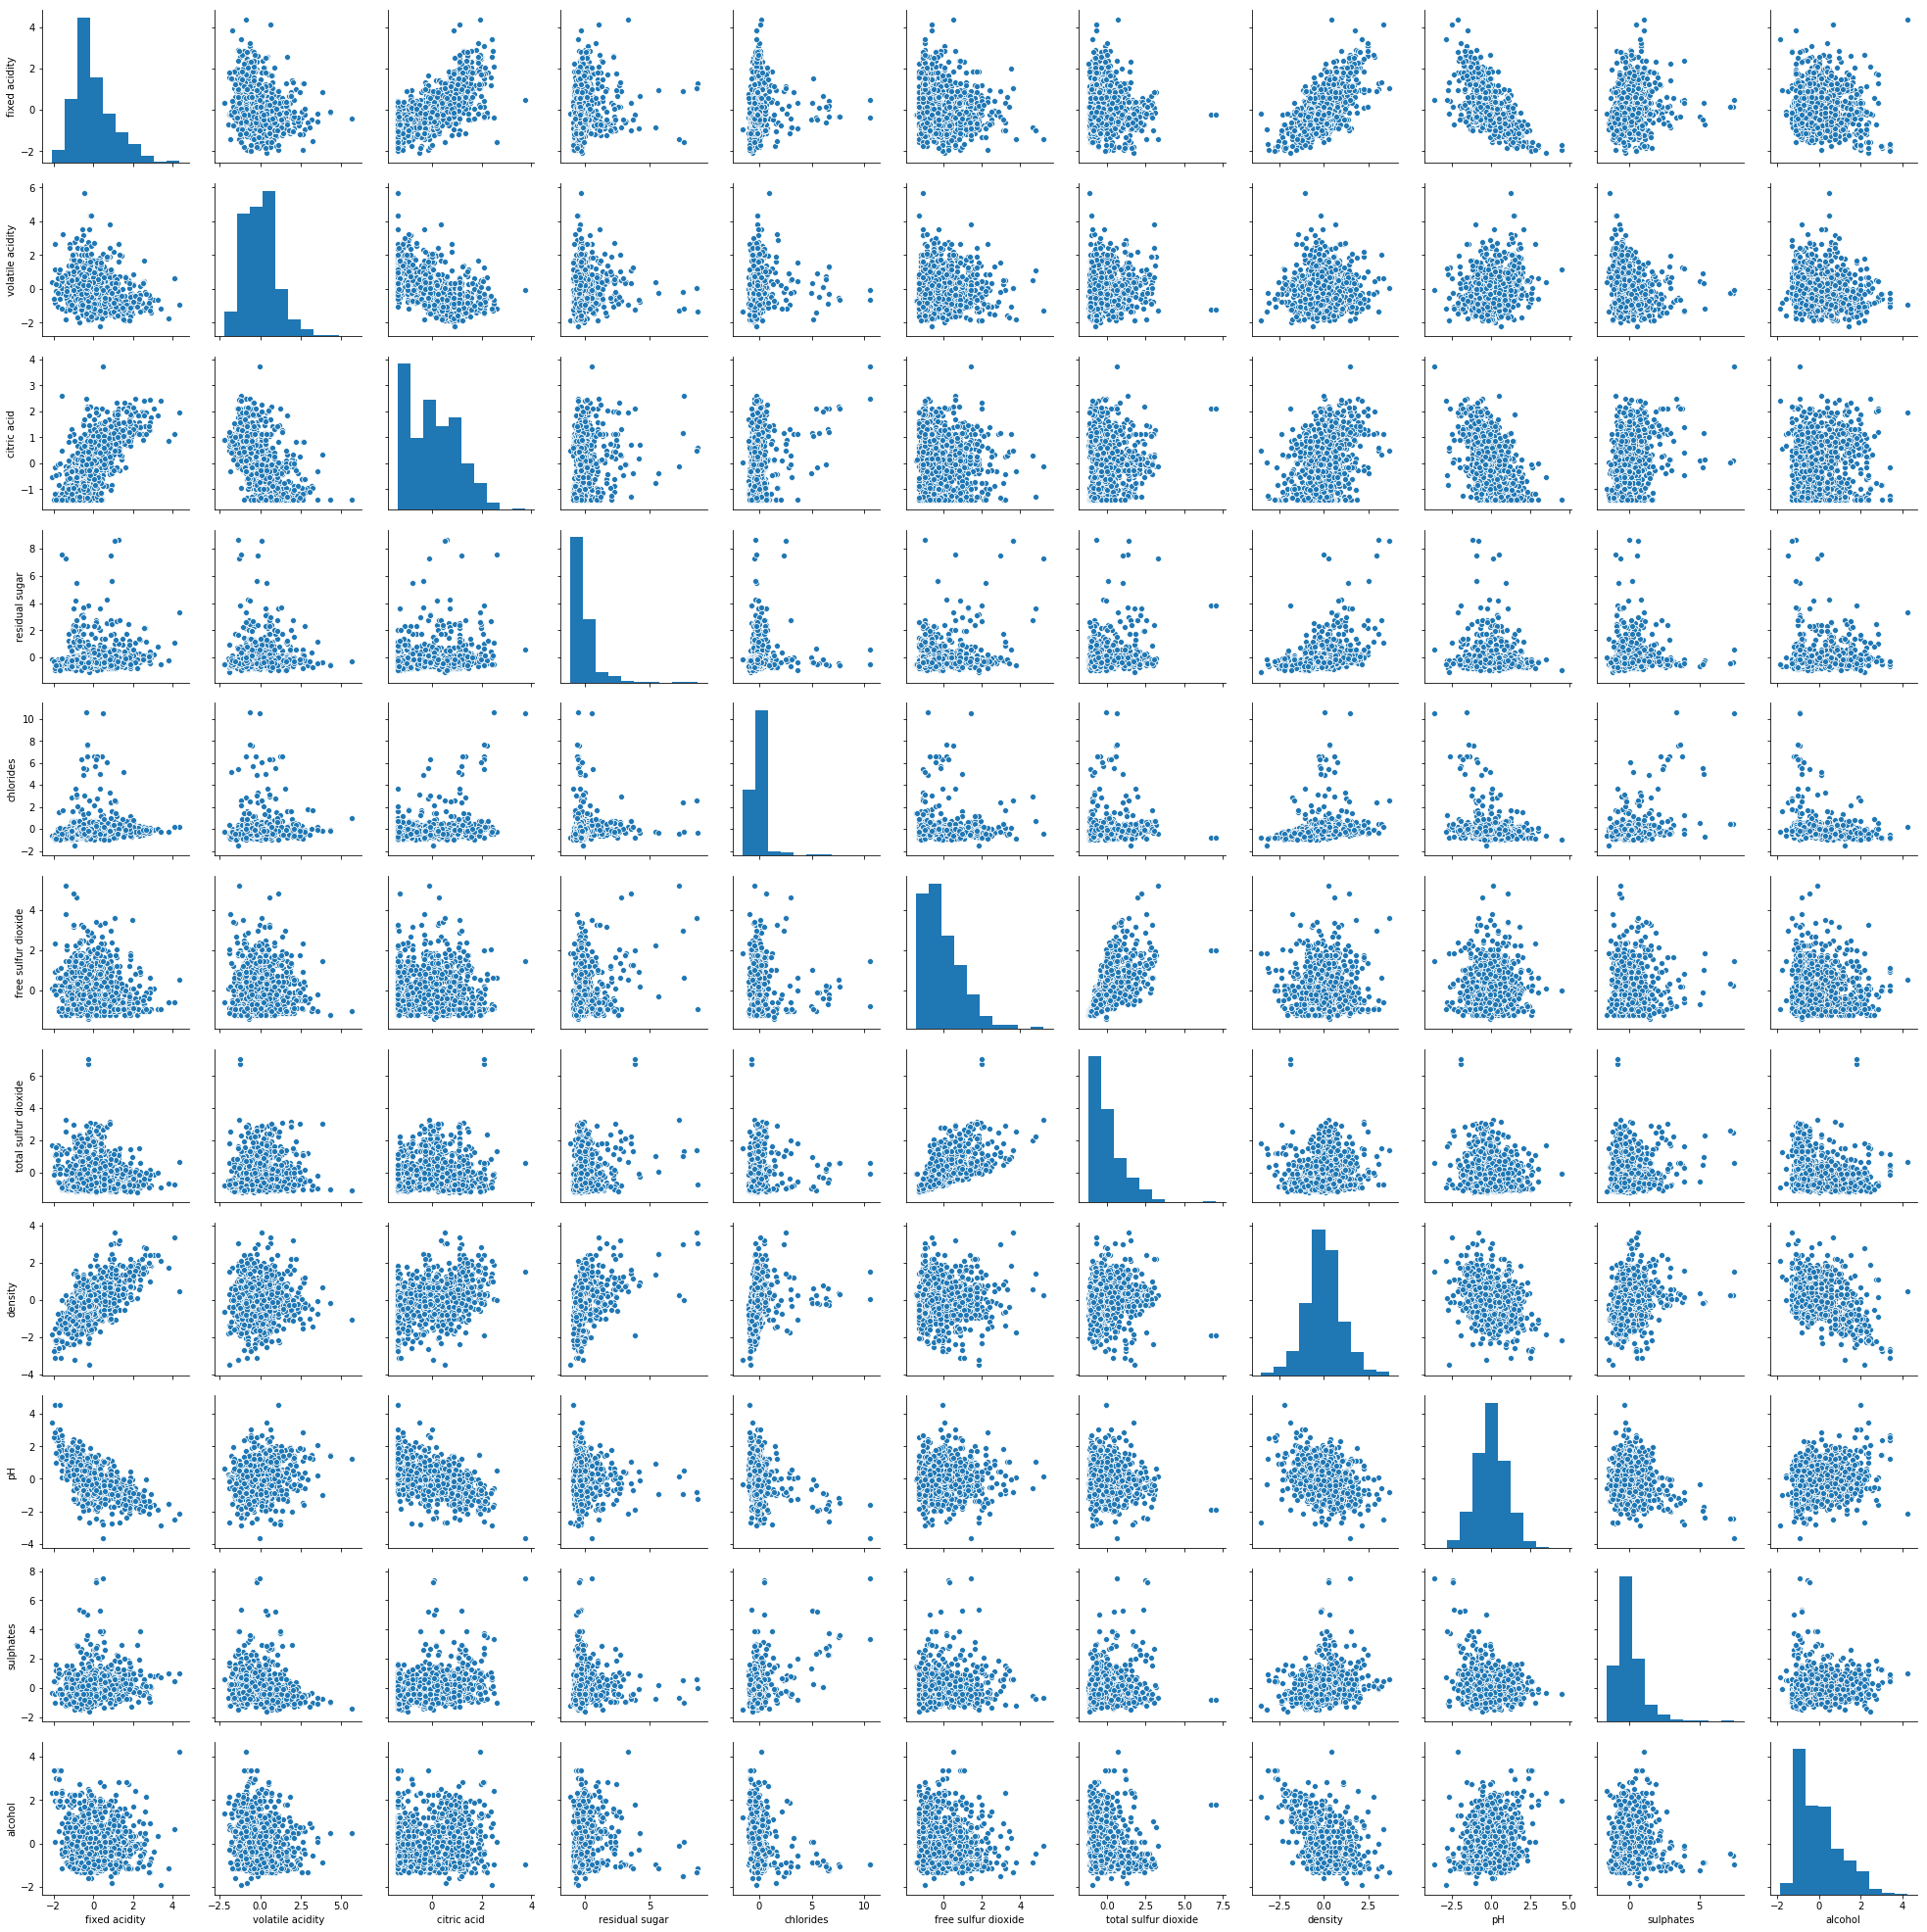

In [648]:
# 散布図行列を表示
sns.pairplot(X_train)

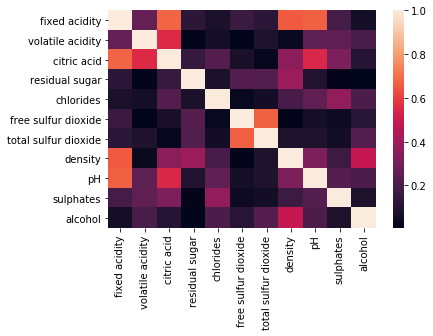

In [649]:
# 相関係数行列とヒートマップ
corr_matrix = X_train.corr()
sns.heatmap(corr_matrix.abs())

In [650]:
corr_matrix.abs().sum().sort_values(ascending=False)

citric acid             4.025635
fixed acidity           3.996454
pH                      3.712360
density                 3.712359
sulphates               2.716379
volatile acidity        2.710874
alcohol                 2.692520
total sulfur dioxide    2.616399
chlorides               2.548287
free sulfur dioxide     2.387581
residual sugar          2.316934
dtype: float64

In [651]:
# 目的変数と各特徴量間の相関係数
corr_y = pd.Series([X_train[col].corr(y_train) for col in X_train.columns], index=X_train.columns)

In [652]:
corr_y.abs().sort_values(ascending = False)

alcohol                 0.462409
volatile acidity        0.424525
citric acid             0.256294
sulphates               0.246085
total sulfur dioxide    0.198564
density                 0.159455
fixed acidity           0.144394
chlorides               0.125352
free sulfur dioxide     0.094731
pH                      0.079785
residual sugar          0.007927
dtype: float64

予想通りと言って良いのかわからないが、他の説明変数との相関が強い特徴量は目的変数との相関が弱い傾向にあるように見える。

fixed acidity は、citric acid, density, pH との相関が高く、目的変数との相関も低いため明らかに排除して良さそう

他はひとまず保留

In [653]:
# del_columns = pd.Index(["fixed acidity"])

In [654]:
# X_train = X_train.drop(del_columns, axis=1)
# X_test = X_test.drop(del_columns, axis=1)

In [655]:
# for col in del_columns:
#     feature_names.remove(col)

## スコア

In [656]:
cross_validation(svm_clf)

Cross-Validation scores: [0.56696429 0.52678571 0.5        0.52678571 0.4529148 ]
Average score: 0.5146901024983984
Test score: 0.4583333333333333


0.5146901024983984

In [657]:
cross_validation(svm_reg)

Cross-Validation scores: [0.45148575 0.42211498 0.38000374 0.4269028  0.3493321 ]
Average score: 0.40596787342893403
Test score: 0.38737273064964606


0.40596787342893403

## 結論
Test scoreに対する結果は悪化した。目的変数への相関が0.01未満の列を全て削って見ても若干の悪化が見られたため、特徴量の削減によってスコアの向上は望めなそうな気がする。

行ったことを振り返ってみると正規化の作業以外で生産性のあることが残念。

In [658]:
X_test.shape

(480, 11)

# リベンジ
目標は勉強会の結果より0.37

スケーリングもstandardscalerに変更

cross_validation関数はvalidの平均を返すように変更

## 特徴量選択

解答の前向き探索の部分を参考に、相関分析の結果の順番で特徴量を追加して結果が向上した場合その特徴量を残すようなやり方で特徴量の選択を行ってみる

In [659]:
# 目的変数間の相関係数ベース
# True, Falseはその場で実行して良い方の順番を採用
importance = corr_y.abs().sort_values(ascending = False).index

In [660]:
good_index = []
min_score = 1000
count = 0
for col in importance:
    
    # 最も良かったときのcolは利用
    using_index = good_index.copy()
#     print(using_index)
    # 新しいcolも追加
    using_index.append(col)
    feature_names = using_index.copy()

    # 実験
    reg_score = cross_validation(svm_reg)
    
    # 結果がよくなっていたら
    if reg_score < min_score:
        count+=1
        print(count)
        
        #結果の更新
        min_score = reg_score
        print(good_index)
        good_index.append(col)
    
    #print(good_index)

Cross-Validation scores: [0.59984633 0.62673599 0.50852951 0.5572304  0.46861829]
Average score: 0.5521921014969338
Test score: 0.45942985495867217
1
[]
Cross-Validation scores: [0.52045499 0.50756146 0.45416105 0.47195491 0.40041718]
Average score: 0.47090991856097497
Test score: 0.46153736025162345
2
['alcohol']
Cross-Validation scores: [0.52001854 0.50659308 0.45354144 0.46837261 0.41838446]
Average score: 0.4733820259266991
Test score: 0.4467461098188451
Cross-Validation scores: [0.47086954 0.46703632 0.44679513 0.4681086  0.35285187]
Average score: 0.4411322908854231
Test score: 0.4057718053789579
3
['alcohol', 'volatile acidity']
Cross-Validation scores: [0.44675176 0.45231704 0.41257644 0.44513185 0.35267334]
Average score: 0.4218900852013556
Test score: 0.3957722481607984
4
['alcohol', 'volatile acidity', 'sulphates']
Cross-Validation scores: [0.45710683 0.45881501 0.41288996 0.44979093 0.3495367 ]
Average score: 0.4256278858452155
Test score: 0.40259665574524645
Cross-Validati

In [661]:
len(feature_names)

9

In [662]:
min_score

0.4076329831305442

In [663]:
# 説明変数間の相関係数ベース
importance2 = corr_matrix.abs().sum().sort_values(ascending=False).index

In [664]:
importance2

Index(['citric acid', 'fixed acidity', 'pH', 'density', 'sulphates',
       'volatile acidity', 'alcohol', 'total sulfur dioxide', 'chlorides',
       'free sulfur dioxide', 'residual sugar'],
      dtype='object')

In [665]:
good_index = []
min_score = 1000
count = 0
for col in importance2:
    
    # 最も良かったときのcolは利用
    using_index = good_index.copy()
#     print(using_index)
    # 新しいcolも追加
    using_index.append(col)
    feature_names = using_index.copy()

    # 実験
    reg_score = cross_validation(svm_reg)
    
    # 結果がよくなっていたら
    if reg_score < min_score:
        
        #結果の更新
        min_score = reg_score
        good_index.append(col)
        print(good_index)
        print(len(good_index))
        
    
    #print(good_index)

Cross-Validation scores: [0.66292545 0.78294041 0.65302052 0.75939604 0.57102031]
Average score: 0.6858605474004769
Test score: 0.630258145230638
['citric acid']
1
Cross-Validation scores: [0.648881   0.72964841 0.62199809 0.70117857 0.55162432]
Average score: 0.6506660784460181
Test score: 0.6305249325518979
['citric acid', 'fixed acidity']
2
Cross-Validation scores: [0.65065446 0.75533153 0.61799145 0.69786518 0.54477323]
Average score: 0.6533231703239736
Test score: 0.6034840443877041
Cross-Validation scores: [0.56428535 0.66271804 0.52718562 0.60958555 0.50291275]
Average score: 0.5733374607726578
Test score: 0.5508002810133819
['citric acid', 'fixed acidity', 'density']
3
Cross-Validation scores: [0.46644706 0.55819392 0.43852694 0.52661285 0.3803168 ]
Average score: 0.47401951454285857
Test score: 0.44318994824028596
['citric acid', 'fixed acidity', 'density', 'sulphates']
4
Cross-Validation scores: [0.48134392 0.50977542 0.4357287  0.48714067 0.36724208]
Average score: 0.4562461

In [666]:
# 現状一番良い
# feature_names = ['citric acid', 'fixed acidity', 'density', 'sulphates', 'volatile acidity', 'alcohol', 'total sulfur dioxide', 'chlorides', 'free sulfur dioxide']
min_score

0.40714857809769106

In [667]:
good_index

['citric acid',
 'fixed acidity',
 'density',
 'sulphates',
 'volatile acidity',
 'alcohol',
 'total sulfur dioxide',
 'chlorides',
 'free sulfur dioxide']

## 邪道に走る
test scoreを基準にしてみる

In [668]:
importance = corr_y.abs().sort_values(ascending = False).index

good_index = []
min_score = 1000
count = 0
for col in importance:
    
    # 最も良かったときのcolは利用
    using_index = good_index.copy()
#     print(using_index)
    # 新しいcolも追加
    using_index.append(col)
    feature_names = using_index.copy()

    # 実験
    reg_score = cross_validation(svm_reg, return_test=True)
    
    # 結果がよくなっていたら
    if reg_score < min_score:
        count+=1
        print(count)
        
        #結果の更新
        min_score = reg_score
        print(good_index)
        good_index.append(col)

Cross-Validation scores: [0.59984633 0.62673599 0.50852951 0.5572304  0.46861829]
Average score: 0.5521921014969338
Test score: 0.45942985495867217
1
[]
Cross-Validation scores: [0.52045499 0.50756146 0.45416105 0.47195491 0.40041718]
Average score: 0.47090991856097497
Test score: 0.46153736025162345
Cross-Validation scores: [0.57114696 0.58693903 0.50851088 0.52319001 0.46144568]
Average score: 0.5302465145683477
Test score: 0.4588773420908803
2
['alcohol']
Cross-Validation scores: [0.50733446 0.52529937 0.47469283 0.51776536 0.38282124]
Average score: 0.48158265186893373
Test score: 0.40379293198108346
3
['alcohol', 'citric acid']
Cross-Validation scores: [0.48418692 0.4909701  0.41067624 0.49067831 0.37166986]
Average score: 0.44963628773071507
Test score: 0.39838175700706985
4
['alcohol', 'citric acid', 'sulphates']
Cross-Validation scores: [0.47055211 0.48878652 0.41406405 0.48832498 0.34841451]
Average score: 0.44202843352059223
Test score: 0.40147536188735755
Cross-Validation sc

In [669]:
# best
min_score

0.3797434022644476

In [670]:
# 説明変数間の相関係数ベース
importance2 = corr_matrix.abs().sum().sort_values(ascending=True).index

good_index = []
min_score = 1000
count = 0
for col in importance2:
    
    # 最も良かったときのcolは利用
    using_index = good_index.copy()
#     print(using_index)
    # 新しいcolも追加
    using_index.append(col)
    feature_names = using_index.copy()

    # 実験
    reg_score = cross_validation(svm_reg, return_test=True)
    
    # 結果がよくなっていたら
    if reg_score < min_score:
        count+=1
        print(count)
        
        #結果の更新
        min_score = reg_score
        print(good_index)
        good_index.append(col)

Cross-Validation scores: [0.75071381 0.80617668 0.71891505 0.82075958 0.6579136 ]
Average score: 0.7508957443565033
Test score: 0.6896016576111627
1
[]
Cross-Validation scores: [0.74398609 0.76601327 0.67757852 0.72697753 0.62323087]
Average score: 0.7075572534591932
Test score: 0.6913352615905184
Cross-Validation scores: [0.74545379 0.72834723 0.6564384  0.80133828 0.59157397]
Average score: 0.7046303355818517
Test score: 0.5915253302539923
2
['residual sugar']
Cross-Validation scores: [0.69683716 0.70349873 0.63944928 0.62958635 0.55025791]
Average score: 0.6439258857664008
Test score: 0.5849885715944855
3
['residual sugar', 'chlorides']
Cross-Validation scores: [0.62083244 0.60133015 0.51639328 0.57186766 0.47079335]
Average score: 0.5562433774565474
Test score: 0.44568699362109426
4
['residual sugar', 'chlorides', 'total sulfur dioxide']
Cross-Validation scores: [0.52950217 0.47405193 0.43828298 0.47484166 0.39794178]
Average score: 0.4629241072155149
Test score: 0.4251970740095346

In [671]:
min_score

0.3936020558191409

あろうことかvalid基準の時よりもスコアが落ちた。

平均的に利用する変数が減ったイメージ

In [672]:
def outlier_for_df(df, n):
    out_df = pd.DataFrame([])
    
    for col in df.columns:
        out_df[col] = outlier(df[col], n)
    
    return out_df.any(axis=1)[out_df.any(axis=1)]

In [673]:
out_df = outlier_for_df(X_train, 6)

In [674]:
# ここまでで一番良かった特徴量
feature_names = ['citric acid', 'fixed acidity', 'density', 'sulphates', 'volatile acidity', 'alcohol', 'total sulfur dioxide', 'chlorides']

In [675]:
cross_validation(svm_reg)

Cross-Validation scores: [0.44951149 0.43982656 0.38661714 0.4450519  0.33235965]
Average score: 0.4106733476763539
Test score: 0.38787826326481656


0.4106733476763539

In [676]:
X_train = X_train.drop(index=out_df.index, axis=0)
y_train = y_train.drop(index=out_df.index)

In [677]:
# 大幅に向上したように見える
# 外れ値の除去が有効？？
cross_validation(svm_reg)

Cross-Validation scores: [0.4443197  0.41113103 0.36979376 0.33695273 0.3528077 ]
Average score: 0.3830009825834978
Test score: 0.3828273275716354


0.3830009825834978

In [678]:
# 最適なn探し

min_score = 10000
good_n = -1
for i in range(20,0,-1):
    # グローバル変数初期化
    X_train, X_test, y_train, y_test = \
        train_test_split(wine_quality_df[feature_names], wine_quality_df["quality"], 
                         test_size=0.3, random_state=0)
    X_train.shape, X_test.shape
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    
    # 実験開始
    out_df = outlier_for_df(X_train, i)
    X_train = X_train.drop(index=out_df.index, axis=0)
    y_train = y_train.drop(index=out_df.index)
    
    score = cross_validation(svm_reg)
    
    # 評価
    if min_score > score:
        min_score = score
        good_n = i

Cross-Validation scores: [0.45303878 0.43783247 0.39093452 0.43537404 0.32467605]
Average score: 0.4083711721358581
Test score: 0.38933373129295673
Cross-Validation scores: [0.45306075 0.43967008 0.39084299 0.43644153 0.32495463]
Average score: 0.40899399650003965
Test score: 0.38949285095167807
Cross-Validation scores: [0.45342613 0.44100232 0.38953759 0.40504714 0.32305747]
Average score: 0.4024141300440884
Test score: 0.3886577852308876
Cross-Validation scores: [0.45413418 0.44534371 0.38713021 0.40854207 0.32034798]
Average score: 0.4030996313156595
Test score: 0.3885350035451365
Cross-Validation scores: [0.45182071 0.44437335 0.38734727 0.40425039 0.31874191]
Average score: 0.40130672486587243
Test score: 0.3894383592037869
Cross-Validation scores: [0.45158099 0.44563078 0.3882247  0.40535665 0.32011421]
Average score: 0.40218146548785283
Test score: 0.38833998212363346
Cross-Validation scores: [0.45354489 0.44762098 0.38885781 0.40532856 0.32150839]
Average score: 0.4033721268510

In [679]:
print("n: ", good_n, "score: ", min_score)

n:  6 score:  0.393615631108143


## 邪道にnを探してみる

In [680]:
# 最適なn探し

min_score = 10000
good_n = -1
for i in range(20,0,-1):
    # グローバル変数初期化
    X_train, X_test, y_train, y_test = \
        train_test_split(wine_quality_df[feature_names], wine_quality_df["quality"], 
                         test_size=0.3, random_state=0)
    X_train.shape, X_test.shape
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    
    # 実験開始
    out_df = outlier_for_df(X_train, i)
    X_train = X_train.drop(index=out_df.index, axis=0)
    y_train = y_train.drop(index=out_df.index)
    
    score = cross_validation(svm_reg, return_test=True)
    
    # 評価
    if min_score > score:
        min_score = score
        good_n = i

Cross-Validation scores: [0.45303878 0.43783247 0.39093452 0.43537404 0.32467605]
Average score: 0.4083711721358581
Test score: 0.38933373129295673
Cross-Validation scores: [0.45306075 0.43967008 0.39084299 0.43644153 0.32495463]
Average score: 0.40899399650003965
Test score: 0.38949285095167807
Cross-Validation scores: [0.45342613 0.44100232 0.38953759 0.40504714 0.32305747]
Average score: 0.4024141300440884
Test score: 0.3886577852308876
Cross-Validation scores: [0.45413418 0.44534371 0.38713021 0.40854207 0.32034798]
Average score: 0.4030996313156595
Test score: 0.3885350035451365
Cross-Validation scores: [0.45182071 0.44437335 0.38734727 0.40425039 0.31874191]
Average score: 0.40130672486587243
Test score: 0.3894383592037869
Cross-Validation scores: [0.45158099 0.44563078 0.3882247  0.40535665 0.32011421]
Average score: 0.40218146548785283
Test score: 0.38833998212363346
Cross-Validation scores: [0.45354489 0.44762098 0.38885781 0.40532856 0.32150839]
Average score: 0.4033721268510

In [681]:
# とても下がった
print("n: ", good_n, "score: ", min_score)

n:  5 score:  0.37134970007494805


## 結果
CVの結果重視で選んだ中で一番良かったやり方を結果にする
- feature_names は 説明変数間の相関係数の絶対値の和を元に高い方から前向き探索を行った結果一番良かった値
- 外れ値のパラメーターは外れ値が0になる20から0までを全て試して一番良かった値

In [684]:
    X_train, X_test, y_train, y_test = \
        train_test_split(wine_quality_df[feature_names], wine_quality_df["quality"], 
                         test_size=0.3, random_state=0)
    X_train.shape, X_test.shape
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    
    # 実験開始
    feature_names = ['citric acid', 'fixed acidity', 'density', 'sulphates', 'volatile acidity', 'alcohol', 'total sulfur dioxide', 'chlorides', 'free sulfur dioxide']
    
    out_df = outlier_for_df(X_train, 6)
    X_train = X_train.drop(index=out_df.index, axis=0)
    y_train = y_train.drop(index=out_df.index)
    
    score = cross_validation(svm_reg, return_test=True)

Cross-Validation scores: [0.46294719 0.4123911  0.38144934 0.3742629  0.36035741]
Average score: 0.39828158948415143
Test score: 0.37360585828401355


比較のため特徴量を全て使ってもやってみる

In [698]:
    X_train, X_test, y_train, y_test = \
        train_test_split(wine_quality_df[feature_names], wine_quality_df["quality"], 
                         test_size=0.3, random_state=0)
    X_train.shape, X_test.shape
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    
   
    feature_names = wine_quality_df.columns[:-1]
    
    out_df = outlier_for_df(X_train, 6)
    X_train = X_train.drop(index=out_df.index, axis=0)
    y_train = y_train.drop(index=out_df.index)
    
    score = cross_validation(svm_reg, return_test=True)

Cross-Validation scores: [0.43716929 0.40773677 0.3925246  0.32109218 0.37580277]
Average score: 0.3868651209635255
Test score: 0.3954400846264979


Test結果は向上していることがわかり、CVの結果に関しても、0.32と並外れて低い結果があるためそれに引っ張られたと読めなくもないため、特徴量選択は正しかったように思う。

最初の結果から比べてどちらのスコアも向上しているため、外れ値処理が有効なこともわかった。

## 感想

結果が周りに比べて悪すぎたのでやり直してみたら思いの外スコアが出て良かったです。解答を見て効果がわかった後ではあるが、途中でやめた外れ値の除去を形にできた点や、前向き探索の順番に相関分析の結果を生かし特徴量の削減で結果の向上ができた点なども満足度が高いです。